In [1]:
# external libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns  # Added for beautiful plots
from scipy import stats # Added for statistical tests
import collections
import networkx as nx
from pathlib import Path
import json

# Update this path to your specific folder
base_dir = r"C:\Users\sumit\Downloads\railway_delays\railway_delays"

# change directory for loading files from disk
sys.path.append(base_dir)
os.chdir(base_dir)
print(os.getcwd())

# custom libraries
try:
    from src.utils.utils import z_score
    from src.data.data_processing import data_interface
except ImportError:
    print("Custom libs not found - skipping (not needed for data creation)")

C:\Users\sumit\Downloads\railway_delays\railway_delays


In [2]:
# set global options
pd.set_option('mode.chained_assignment', None)
figsize = (5, 4)
dpi = 300
node_size = 6
# Set Seaborn style for better graphs
sns.set(style="whitegrid")

In [3]:
# include all these data points
raw_dir = "./data/raw/"
interim_dir = "./data/interim/"
processed_dir = "./data/processed/"
Path(raw_dir).mkdir(parents=True, exist_ok=True)
Path(interim_dir).mkdir(parents=True, exist_ok=True)
Path(processed_dir).mkdir(parents=True, exist_ok=True)

# input data locations
raw_data_path_2016 = raw_dir + "HSP_2016_DID_PAD.txt"
raw_data_path_2017 = raw_dir + "HSP_2017_DID_PAD.txt"
stop_location_path = raw_dir + "stations.csv"

# save locations
adjlist_path = interim_dir + "adjlist.txt"
adj_path = processed_dir + "adj.npy"
dataset_path = processed_dir + "dataset.npy"

# Paths for new mapping files
g_stop2idx_path = processed_dir + "G_stop2idx.json"
g_idx2stop_path = processed_dir + "G_idx2stop.json"
lg_node2idx_path = processed_dir + "LG_node2idx.json"
lg_idx2node_path = processed_dir + "LG_idx2node.json"
lg_node2label_path = processed_dir + "LG_node2label.json"

In [ ]:
df1 = pd.read_csv(raw_data_path_2016, sep=",")
df2 = pd.read_csv(raw_data_path_2017, sep=",")    #Loading & Merging Data
if "Unnamed: 0" in df2.columns:
    df2 = df2.drop(["Unnamed: 0"], axis=1)
df = pd.concat([df1, df2])

# 2017 includes XXXPAD and PADXXX trips, 2016 does not, so remove the outbound trips
df = df[df["station_origin"] != "PAD"]

# remove any stops that are included in either year but not the other
stops_2016 = np.unique(df1["station_curr"])
stops_2017 = np.unique(df2["station_curr"])
stops_drop = []

for i in stops_2017:
    if i not in stops_2016:
        stops_drop.append(i)
for i in stops_2016:
    if i not in stops_2017:
        stops_drop.append(i)
for i in stops_drop:
    df = df[df["station_curr"] != i]
    ## Removing Low-Traffic Stations (Noise Reduction)
# remove stations that serve an average of less than stop_thres trains per day 
stations = np.unique(df["station_curr"])
n_days = len(np.unique(df["date"]))
# stops per station
sps = dict(collections.Counter(df["station_curr"]))
sps = dict(sorted(sps.items()))

# if you change this value you will have to manually change the corridors and available routes
stop_thres = 1
counter = 0
for i in list(sps):
    if (sps[i] / n_days) < stop_thres:
        # find set of RID's associated with these
        df_tmp = df.loc[df["station_curr"] == i]
        RID_drop = np.unique(df_tmp["RID"])
        # remove train routes that stop at any of the non-included stations
        for j in RID_drop:
            df = df.loc[df["RID"] != j]
        sps.pop(i)

df = df.reset_index()
df = df.drop(["index"], axis=1)
print(f"Filtered DataFrame shape: {df.shape}")

Filtered DataFrame shape: (104012, 15)


In [ ]:
stops_data_period = np.unique(df["station_curr"]) #Geospatial Mapping Step.
df_sp = pd.read_csv(stop_location_path)
G_stop2location = {}
for i in range(len(df_sp)):
    curr_row = df_sp[i:i+1]
    if curr_row["crs"].item() in stops_data_period:
        G_stop2location[curr_row["crs"].item()] = (curr_row["lat"].item(), curr_row["lon"].item())
print(f"Loaded {len(G_stop2location)} station locations.")

Loaded 41 station locations.


In [ ]:
# --------------------------------------------
# Northwest Corridor
# --------------------------------------------
# used in defining the graph
corridor_list = [
    ["SWA", "NTH", "PTA", "BGN", "CDF", "NWP", "BPW", "SWI"],
    ["WSM", "WNM", "WOR", "YAT", "NLS", "BRI", "BTH", "CPM", "SWI"],
    ["SWI", "DID"],
    ["BAN", "KGS", "HYD", "TAC", "OXF", "RAD", "CUM", "APF", "DID"],
    ["DID", "CHO", "GOR", "PAN", "TLH", "RDG", "TWY", "MAI", "BNM", "SLO", "LNY",
     "IVR", "WDT", "HAY", "STL", "EAL", "PAD"]
     
]
"""
corridor_list = [
    ["SWA", "NTH", "PTA", "BGN", "CDF", "NWP", "BPW", "SWI"],  # Corridor 1: South Wales
    ["WSM", "WNM", "WOR", "YAT", "NLS", "BRI", "BTH", "CPM", "SWI"], # Corridor 2: West/Bristol
    ["SWI", "DID"],                                            # Corridor 3: The "Bridge"
    ["BAN", ... , "DID"],                                      # Corridor 4: North/Oxford
    ["DID", ... , "PAD"]                                       # Corridor 5: Main Line to London
]
"""
# rearrange sps with stops grouped by corridor
sps_tmp = {}
for corridor in corridor_list:
    for j in corridor:
        keys = list(sps_tmp)
        if j not in keys:
            sps_tmp[j] = sps[j]
sps = sps_tmp

# used in finding links between stops
available_routes = [
    ["SWA", "NTH", "PTA", "BGN", "CDF", "NWP", "BPW", "SWI", "DID", "CHO",
     "GOR", "PAN", "TLH", "RDG", "TWY", "MAI", "BNM", "SLO", "LNY",
     "IVR", "WDT", "HAY", "STL", "EAL", "PAD"], # Route 1: From Swansea
    
    ["WSM", "WNM", "WOR", "YAT", "NLS", "BRI", "BTH", 
     "CPM", "SWI", "DID", "CHO", "GOR", "PAN", "TLH", "RDG", "TWY", "MAI",
     "BNM", "SLO", "LNY", "IVR", "WDT", "HAY", "STL", "EAL", "PAD"], # Route 2: From Bristol/Weston
    
    ["BAN", "KGS", "HYD", "TAC", "OXF", "RAD", "CUM", "APF", "DID", "CHO",
     "GOR", "PAN", "TLH", "RDG", "TWY", "MAI", "BNM", "SLO", "LNY",
     "IVR", "WDT", "HAY", "STL", "EAL", "PAD"] # Route 3: From Banbury/Oxford
]
print(f"Defined {len(corridor_list)} corridors and {len(available_routes)} routes.")

Defined 5 corridors and 3 routes.


In [ ]:
def get_links(stop_1, stop_2, available_routes):
    # returns a list of all links between two stops on a route
    done = 0
    link_list = []
    for i in range(len(available_routes)):
        curr_route = available_routes[i]
        if (stop_1 in curr_route) and (stop_2 in curr_route) and (not done):
            done = 1
            stop_1_idx = curr_route.index(stop_1)
            stop_2_idx = curr_route.index(stop_2)            
            for j in range(stop_1_idx, stop_2_idx):                
                link_list.append(curr_route[j] + curr_route[j+1])
        
    return link_list #Link Generation

In [ ]:
# t transforms the raw text timestamps into mathematical values that a machine learning model can understand. Specifically, it calculates the Link Delay  and Link Travel Time.
# dataframe setup
df["OD"] = df["station_origin"] + df["station_destination"]

# get integer time values for all rows
df["dep_sched_int"] = df["departure_sched"]
df["dep_sched_int"][df["dep_sched_int"] == "terminating"] = df["arrival_sched"]
df["dep_actual_int"] = df["departure_actual"]
df["dep_actual_int"][df["dep_actual_int"] == "terminating"] = df["arrival_actual"]

# this one is different b/c "starting" arrival delay must be 0
df["arr_sched_int"] = df["arrival_sched"]
df["arr_sched_int"][df["arr_sched_int"] == "starting"] = df["departure_actual"]
df["arr_actual_int"] = df["arrival_actual"]
df["arr_actual_int"][df["arr_actual_int"] == "starting"] = df["departure_actual"]

# get scheduled arrival and departure as datetime
df["arr_sched_datetime"] = pd.to_datetime(df["date"].astype(str) + " " + df["arr_sched_int"].astype(str))
df["dep_sched_datetime"] = pd.to_datetime(df["date"].astype(str) + " " + df["dep_sched_int"].astype(str))
df["arr_actual_datetime"] = pd.to_datetime(df["date"].astype(str) + " " + df["arr_actual_int"].astype(str))
df["dep_actual_datetime"] = pd.to_datetime(df["date"].astype(str) + " " + df["dep_actual_int"].astype(str))

# --- STATION DELAY CALCULATION ---
# cum_arr_delay = The ACTUAL delay at the station (What you want to predict in the end)
df["cum_arr_delay"] = ((df["arr_actual_datetime"] - df["arr_sched_datetime"]).dt.total_seconds()) / 60
#  Calculating Link Metrics
init_list = []
for i in range(len(df)):
    init_list.append([])
df["prev_links"] = init_list

# --- NEW: Initialize Travel Time Column ---
df["prev_link_time"] = 0.0 

# make sure we're only combining data from one train trip at a time
for row_count in range(len(df)):
    curr_row = df[row_count:row_count+1]
    if (curr_row["arrival_sched"].item() == "starting"):
        df.at[row_count, "prev_link_avg_datetime"] = df.at[row_count, "dep_sched_datetime"]
        df.at[row_count, "prev_link_delay"] = 0.
        df.at[row_count, "prev_link_time"] = 0. # Start has 0 travel time
        df.at[row_count, "prev_links"] = []
        df.at[row_count, "prev_station_dep_sched_datetime"] = df.at[row_count, "dep_sched_datetime"]

    else:
        prev_row = df[row_count-1:row_count]
        t0 = prev_row["dep_sched_datetime"].item()
        t1 = curr_row["arr_sched_datetime"].item()
        df.at[row_count, "prev_link_avg_datetime"] = t0 + ((t1-t0) / 2)
        prev_links = get_links(prev_row["station_curr"].item(), curr_row["station_curr"].item(), available_routes)
        df.at[row_count, "prev_links"] = prev_links
        df.at[row_count, "prev_station_dep_sched_datetime"] = prev_row["dep_sched_datetime"].item()

        # --- LINK DELAY CALCULATION ---
        # This is what the model learns (Change in delay)
        n_links = len(prev_links)
        if (n_links == 0): n_links = 1
        df.at[row_count, "prev_link_delay"] = (curr_row["cum_arr_delay"].item() - prev_row["cum_arr_delay"].item()) / n_links
        
        # --- NEW: LINK TRAVEL TIME (SPEED) ---
        # We get the actual travel time from the raw data and distribute it across links
        total_travel_time = curr_row["travel_time_actual"].item()
        df.at[row_count, "prev_link_time"] = total_travel_time / n_links
        
    row_count += 1
        
# alphabetize columns
df = df.reindex(sorted(df.columns), axis=1)
print("Feature engineering complete. Link Delay and Travel Time calculated.")

# A. Route Info 16. OD: Combined Origin + Destination string.

# B. Fixed Time Strings (Converted "starting/terminating" to numbers) 17. dep_sched_int 18. dep_actual_int 19. arr_sched_int 20. arr_actual_int

# C. Datetime Objects (Converted strings to real timestamps) 21. arr_sched_datetime 22. dep_sched_datetime 23. arr_actual_datetime 24. dep_actual_datetime

# D. The Critical Calculations (Target Variables) 25. cum_arr_delay: The delay at the current station (Actual - Scheduled).
# 26. prev_links: The ID of the track segment used to get here. 27. prev_link_time: The time spent traveling on that track. 
# 28. prev_link_avg_datetime: The midpoint time (used to slot data into 10-min buckets). 29. prev_link_delay: The delay generated on the previous track (Model Target).
# 30. prev_station_dep_sched_datetime: When the train left the previous station.

C:\Users\sumit\AppData\Local\Temp\ipykernel_19788\3875399772.py:67: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["dep_sched_int"][df["dep_sched_int"] == "terminating"] = df["arrival_sched"]
C:\Users\sumit\AppData\Local\Temp\ipykernel_197

Feature engineering complete. Link Delay and Travel Time calculated.


--- EDA STEP 1: Data Information ---
Shape of Processed Data: (104012, 30)

Missing Values check:
cum_arr_delay      0
prev_link_delay    0
prev_link_time     0
dtype: int64

--- Station Delay Stats (Minutes) ---
count    104012.000000
mean          1.372890
std           4.062539
min         -15.000000
25%          -1.000000
50%           0.000000
75%           2.000000
max          86.000000
Name: cum_arr_delay, dtype: float64

--- Link Travel Time Stats (Minutes) ---
count    104012.000000
mean          5.402843
std           4.631376
min           0.000000
25%           3.000000
50%           4.000000
75%           6.000000
max         102.000000
Name: prev_link_time, dtype: float64


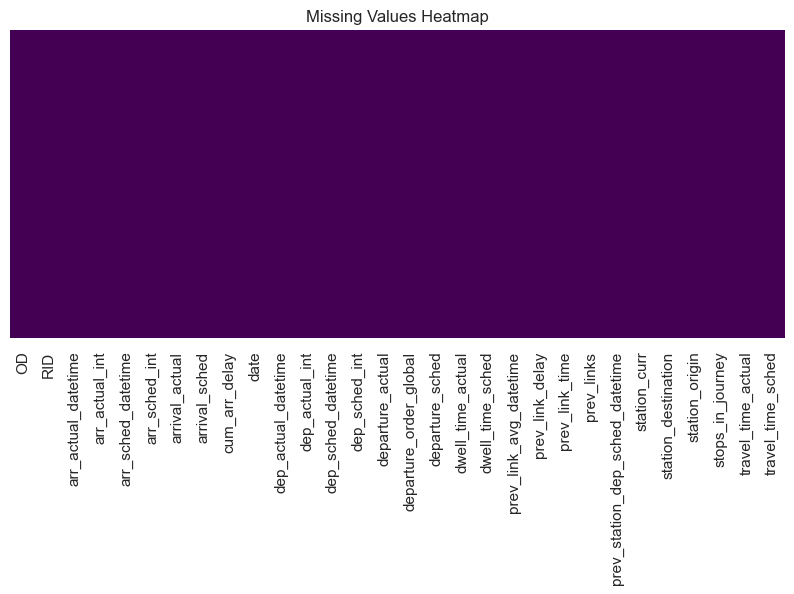

In [9]:
print("--- EDA STEP 1: Data Information ---")
print("Shape of Processed Data:", df.shape)
print("\nMissing Values check:")
print(df[['cum_arr_delay', 'prev_link_delay', 'prev_link_time']].isnull().sum())

# Summary statistics
print("\n--- Station Delay Stats (Minutes) ---")
print(df['cum_arr_delay'].describe())

print("\n--- Link Travel Time Stats (Minutes) ---")
print(df['prev_link_time'].describe())

# Visualize Missing Values
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

--- EDA STEP 2: Distributions ---


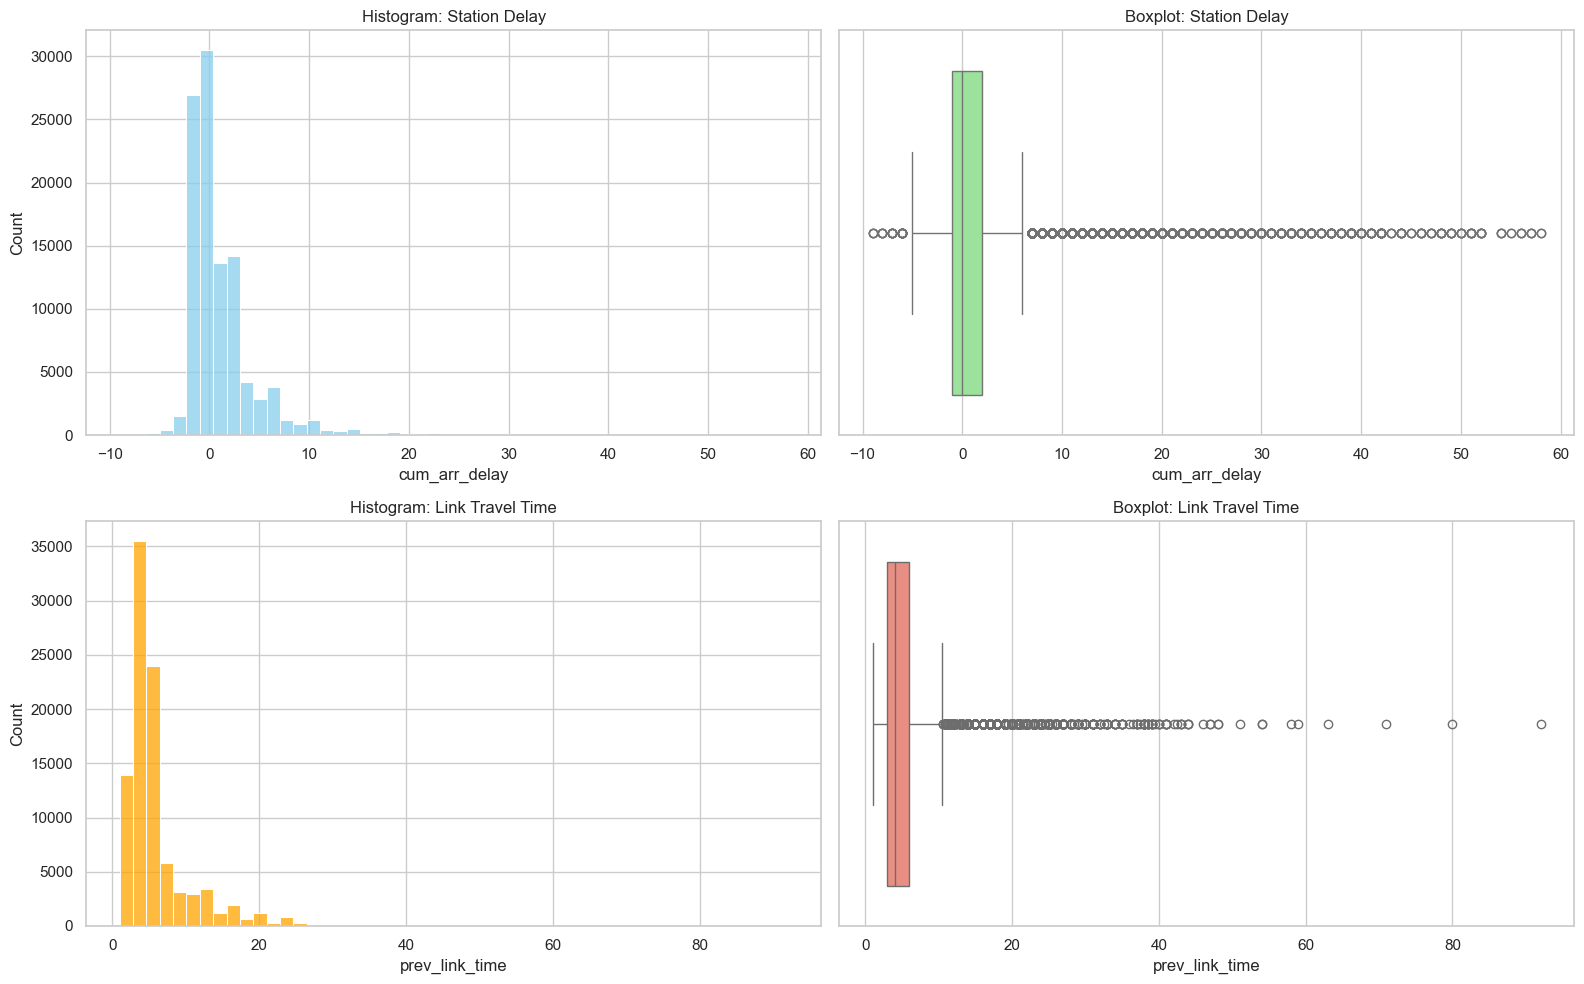

In [10]:
print("--- EDA STEP 2: Distributions ---")
# Filter for reasonable plot range
df_plot = df[(df['cum_arr_delay'] > -10) & (df['cum_arr_delay'] < 60)]
df_speed = df[(df['prev_link_time'] > 0) & (df['prev_link_time'] < 100)]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Station Delay Plots
sns.histplot(df_plot['cum_arr_delay'], bins=50, ax=axes[0,0], color='skyblue').set_title("Histogram: Station Delay")
sns.boxplot(x=df_plot['cum_arr_delay'], ax=axes[0,1], color='lightgreen').set_title("Boxplot: Station Delay")

# Travel Time Plots (NEW)
sns.histplot(df_speed['prev_link_time'], bins=50, ax=axes[1,0], color='orange').set_title("Histogram: Link Travel Time")
sns.boxplot(x=df_speed['prev_link_time'], ax=axes[1,1], color='salmon').set_title("Boxplot: Link Travel Time")

plt.tight_layout()
plt.show()

--- EDA STEP 3: Delay Propagation (Flow Analysis) ---


C:\Users\sumit\AppData\Local\Temp\ipykernel_19788\2430738969.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=route_df, x="station_curr", y="cum_arr_delay", estimator="mean", ci=95, marker="o", color="red")


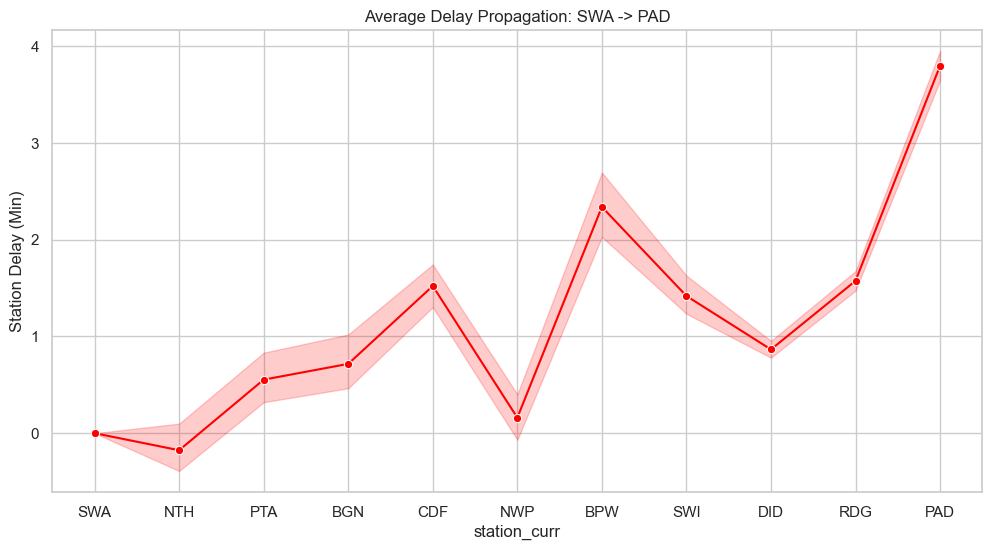

In [11]:
print("--- EDA STEP 3: Delay Propagation (Flow Analysis) ---")
route_stations = ["SWA", "NTH", "PTA", "BGN", "CDF", "NWP", "BPW", "SWI", "DID", "RDG", "PAD"]
route_df = df[df["station_curr"].isin(route_stations)]
route_df["station_curr"] = pd.Categorical(route_df["station_curr"], categories=route_stations, ordered=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=route_df, x="station_curr", y="cum_arr_delay", estimator="mean", ci=95, marker="o", color="red")
plt.title("Average Delay Propagation: SWA -> PAD")
plt.ylabel("Station Delay (Min)")
plt.grid(True)
plt.show()

--- EDA STEP 4: Statistical Test (Peak vs Off-Peak) ---
Average Peak Delay:     1.46 min
Average Off-Peak Delay: 1.24 min
T-Test P-Value:         0.00000
CONCLUSION:  Significant difference found. Peak hours have different delays.


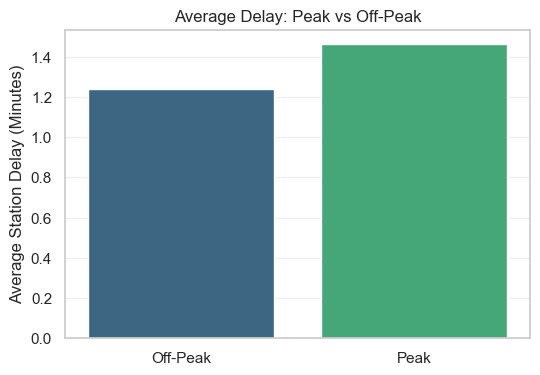

In [12]:
print("--- EDA STEP 4: Statistical Test (Peak vs Off-Peak) ---")

# Define Peak Hours: 07:00-10:00 and 16:00-19:00
# We use the 'hour' from the scheduled arrival time
df['hour'] = df['arr_sched_datetime'].dt.hour
df['is_peak'] = df['hour'].apply(lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 18) else 0)

# Separate the data
peak_delays = df[df['is_peak'] == 1]['cum_arr_delay'].dropna()
offpeak_delays = df[df['is_peak'] == 0]['cum_arr_delay'].dropna()

# Perform T-Test (Welch's t-test, equal_var=False)
t_stat, p_val = stats.ttest_ind(peak_delays, offpeak_delays, equal_var=False)

# Print Statistics
print(f"Average Peak Delay:     {peak_delays.mean():.2f} min")
print(f"Average Off-Peak Delay: {offpeak_delays.mean():.2f} min")
print(f"T-Test P-Value:         {p_val:.5f}")

# Conclusion Logic
if p_val < 0.05:
    print("CONCLUSION:  Significant difference found. Peak hours have different delays.")
else:
    print("CONCLUSION:  No significant difference found.")

# Plot the Result
plt.figure(figsize=(6, 4))
# Note: Adding hue=x to avoid future warnings in Seaborn
sns.barplot(x=['Off-Peak', 'Peak'], y=[offpeak_delays.mean(), peak_delays.mean()], palette="viridis", hue=['Off-Peak', 'Peak'], legend=False)
plt.title("Average Delay: Peak vs Off-Peak")
plt.ylabel("Average Station Delay (Minutes)")
plt.grid(axis='y', alpha=0.3)
plt.show()

--- EDA STEP 6: All-Feature Correlation Analysis ---

Most Correlated Features with Link Delay:
cum_arr_delay         0.378324
prev_link_time        0.193074
travel_time_actual    0.167133
is_peak               0.040132
travel_time_sched     0.012655
dwell_time_sched     -0.023279
stops_in_journey     -0.044944
hour                 -0.047514
dwell_time_actual    -0.131119
Name: prev_link_delay, dtype: float64


C:\Users\sumit\AppData\Local\Temp\ipykernel_19788\3670232687.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")


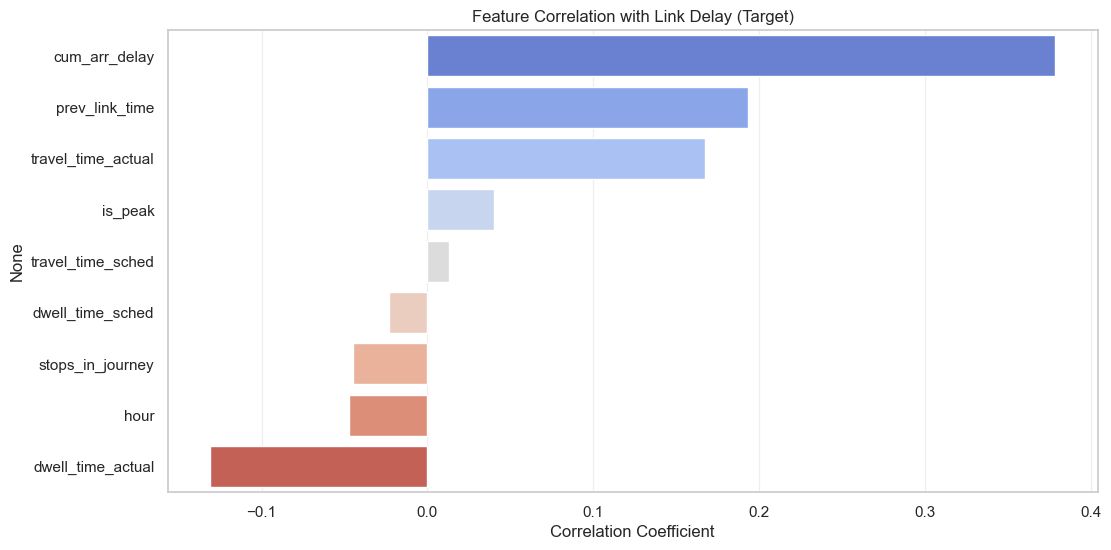


--- What this tells you ---
POSITIVE BAR (Red/Right): As this feature increases, Delay INCREASES.
NEGATIVE BAR (Blue/Left): As this feature increases, Delay DECREASES (Recovery).
Strongest Predictor: 'cum_arr_delay' (Corr: 0.38)


In [ ]:
print("--- EDA STEP 5: All-Feature Correlation Analysis ---")

# 1. Prepare Data for Correlation
# Select only numerical columns
numerical_df = df.select_dtypes(include=[np.number])

# Remove columns that are just IDs or internal indices (not useful for prediction)
cols_to_drop = ['RID', 'departure_order_global', 'index', 'Unnamed: 0']
numerical_df = numerical_df.drop(columns=[c for c in cols_to_drop if c in numerical_df.columns])

# 2. Calculate Correlation with Target (prev_link_delay)
# We want to know: Which columns predict 'prev_link_delay' the best?
if 'prev_link_delay' in numerical_df.columns:
    target_corr = numerical_df.corr()['prev_link_delay'].sort_values(ascending=False)
    
    # Drop the target itself (correlation 1.0)
    target_corr = target_corr.drop('prev_link_delay')

    print("\nMost Correlated Features with Link Delay:")
    print(target_corr)

    # 3. Plot Correlation Bar Chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")
    plt.title("Feature Correlation with Link Delay (Target)")
    plt.xlabel("Correlation Coefficient")
    plt.grid(axis='x', alpha=0.3)
    plt.show()

    # 4. Explanation
    print("\n--- What this tells you ---")
    print("POSITIVE BAR (Red/Right): As this feature increases, Delay INCREASES.")
    print("NEGATIVE BAR (Blue/Left): As this feature increases, Delay DECREASES (Recovery).")
    
    top_feat = target_corr.index[0]
    print(f"Strongest Predictor: '{top_feat}' (Corr: {target_corr.iloc[0]:.2f})")

else:
    print("Error: 'prev_link_delay' column not found. Make sure Cell 8 ran successfully.")

In [14]:
counter = 0
G_stop2idx = {}
G_idx2stop = {}
for i in list(sps):
    G_stop2idx[i] = counter
    G_idx2stop[counter] = str(i)
    counter += 1
print(f"Created {len(G_stop2idx)} station mappings.")

Created 41 station mappings.


In [ ]:
total_str = ""  #understand connections.
for corridor in corridor_list:
    for j in range(len(corridor)):
        tmp_str = ""
        if (j == 0):
            tmp_str += str(G_stop2idx[corridor[j]]) + " " + str(G_stop2idx[corridor[j+1]])
        elif (j == len(corridor)-1):
            tmp_str += str(G_stop2idx[corridor[j]]) + " " + str(G_stop2idx[corridor[j-1]])
        else:
            tmp_str += str(G_stop2idx[corridor[j]]) + " " + str(G_stop2idx[corridor[j-1]]) + " " + str(G_stop2idx[corridor[j+1]])
        total_str += tmp_str + "\n"

with open(adjlist_path, "w") as f:
    f.write(total_str)
print(f"Saved adjacency list to {adjlist_path}")

Saved adjacency list to ./data/interim/adjlist.txt


In [ ]:
G_idx2location = {} #Graph Transformation
counter = 0
for i in G_stop2location:
    G_idx2location[G_stop2idx[i]] = (G_stop2location[i][1], G_stop2location[i][0])

G = nx.read_adjlist(adjlist_path, nodetype=int)
LG = nx.line_graph(G)
print(f"Station Graph (G) nodes: {G.number_of_nodes()}")
print(f"Line Graph (LG) nodes: {LG.number_of_nodes()}")

Station Graph (G) nodes: 41
Line Graph (LG) nodes: 40


In [ ]:
LG_node2location = {} #Final Graph Preparations converts the graph into the mathematical matrix needed
for edge in LG.nodes(): #Calculating Link Coordinates
    station_1 = int(edge[0])
    station_2 = int(edge[1])
    x1, x2 = G_idx2location[station_1][0], G_idx2location[station_2][0]
    y1, y2 = G_idx2location[station_1][1], G_idx2location[station_2][1]
    LG_node2location[edge] = ((x1+x2)/2, (y1+y2)/2)

In [ ]:
LG_node2label = {} #Naming the Links
for edge in LG.nodes():
    station_1 = int(edge[0])
    station_2 = int(edge[1])
    if (G_idx2stop[station_1] == "SWI") and (G_idx2stop[station_2] == "CPM") or \
        (G_idx2stop[station_1] == "DID") and (G_idx2stop[station_2] == "APF"):
        station_tmp = station_1
        station_1 = station_2
        station_2 = station_tmp
    LG_node2label[edge] = G_idx2stop[station_1] + G_idx2stop[station_2]

In [ ]:
for i in LG.nodes: #Adjacency Matrix & Self-Loops :It connects every node to itself.
    LG.add_edge(i, i)
adj = nx.adjacency_matrix(LG).todense()
adj = np.array(adj).astype("float64")
np.save(adj_path, adj)
print(f"Adjacency matrix saved with shape: {adj.shape}")

Adjacency matrix saved with shape: (40, 40)


In [ ]:
def round_time(t_input, dt, direction="floor"): #Time Discretization
    if direction == "floor":
        n_minutes = ((pd.to_timedelta(str(t_input[0:2] + ":" + t_input[2:4] + ":00")).seconds / 60) // dt * dt)
        return pd.to_timedelta(n_minutes, unit="m")
    elif direction == "ceil":
        n_minutes = ((pd.to_timedelta(str(t_input[0:2] + ":" + t_input[2:4] + ":00")).seconds / 60 + dt) // dt * dt)
        return pd.to_timedelta(n_minutes, unit="m")

dt = 10
t_min = min(df["dep_sched_int"])
t_max = max(df["dep_sched_int"])
t_start = round_time(t_min, dt)
t_end = round_time(t_max, dt, "ceil")

time_list = []
t_curr = t_start
while t_curr < t_end:
    time_list.append(t_curr)
    t_curr += pd.Timedelta(str(dt) + "minutes")

date_list = np.unique(df["date"])
datetime_list = []
for i in date_list:
    t0 = pd.to_datetime(i + " 00:00:00")
    for j in time_list:
        t_curr = t0 + j
        datetime_list.append(t_curr)
print(f"Created {len(datetime_list)} total 10-minute timesteps.")

Created 21336 total 10-minute timesteps.


In [21]:
LG_node2idx = {}
LG_idx2node = {}
counter = 0
for i in LG.nodes():
    LG_node2idx[i] = counter
    LG_idx2node[counter] = i
    counter += 1

LG_node_label = LG_node2label
LG_label2node = {}
for i in LG_node_label:
    LG_label2node[LG_node_label[i]] = i

datetime2idx = {}
idx2datetime = {}
counter = 0
for i in datetime_list:
    datetime2idx[i] = counter
    idx2datetime[counter] = i
    counter += 1

with open(g_stop2idx_path, 'w') as f: json.dump(G_stop2idx, f)
with open(g_idx2stop_path, 'w') as f: json.dump(G_idx2stop, f)
LG_node2idx_str_keys = {str(k): v for k, v in LG_node2idx.items()}
with open(lg_node2idx_path, 'w') as f: json.dump(LG_node2idx_str_keys, f)
LG_idx2node_str_keys = {k: str(v) for k, v in LG_idx2node.items()}
with open(lg_idx2node_path, 'w') as f: json.dump(LG_idx2node_str_keys, f)
LG_node2label_str_keys = {str(k): v for k, v in LG_node2label.items()}
with open(lg_node2label_path, 'w') as f: json.dump(LG_node2label_str_keys, f)
print("Saved all mappings.")

Saved all mappings.


In [ ]:

n_nodes = len(adj)
n_timesteps = len(datetime_list)

# --- 6 FEATURES ---
# 0: Delay
# 1: Time_Sin
# 2: Time_Cos
# 3: Day_Sin
# 4: Day_Cos
# 5: Travel Time (Speed) - NEW
n_features = 6 

n_timesteps_per_day = ((t_end - t_start)/dt).seconds / 60
delay_dataset = np.zeros((n_timesteps, n_nodes, n_features))
n_trains_total = np.zeros((n_nodes, 1))
n_trains_link_dt = np.zeros((n_timesteps, n_nodes, 1))

print("Generating Advanced Dataset (6 Features)...")

for i in range(len(datetime_list)-1):
    t0, t1 = datetime_list[i], datetime_list[i+1]
    
    # --- Time Features ---
    minute_of_day = t0.hour * 60 + t0.minute
    time_sin = np.sin(2 * np.pi * minute_of_day / 1440.0)
    time_cos = np.cos(2 * np.pi * minute_of_day / 1440.0)
    day_of_week = t0.weekday()
    day_sin = np.sin(2 * np.pi * day_of_week / 7.0)
    day_cos = np.cos(2 * np.pi * day_of_week / 7.0)
    
    # Assign Time Features (Same for all links at this time)
    delay_dataset[i, :, 1] = time_sin
    delay_dataset[i, :, 2] = time_cos
    delay_dataset[i, :, 3] = day_sin
    delay_dataset[i, :, 4] = day_cos
    
    # Find trains running now
    t_avg_cond = ((t0 <= df["prev_link_avg_datetime"]) & (df["prev_link_avg_datetime"] <= t1))
    t_arr_cond = ((t0 <= df["arr_sched_datetime"]) & (df["arr_sched_datetime"] <= t1))
    t_dep_cond = ((t0 <= df["prev_station_dep_sched_datetime"]) & (df["prev_station_dep_sched_datetime"] <= t1))
    
    df_tmp = df.loc[t_avg_cond | t_dep_cond | t_arr_cond]
    n_trains_link = np.zeros((n_nodes, 1))

    for j in range(len(df_tmp)):
        curr_row = df_tmp[j:j+1]
        prev_links = curr_row["prev_links"].item()

        for k in range(len(prev_links)):
            link = prev_links[k]
            if link in LG_label2node:
                link_idx = LG_node2idx[LG_label2node[link]]
                
                # Feature 0: Link Delay
                delay_dataset[i, link_idx, 0] += curr_row["prev_link_delay"].item()
                
                # Feature 5: Link Travel Time (Speed)
                delay_dataset[i, link_idx, 5] += curr_row["prev_link_time"].item()
                
                n_trains_link[link_idx] += 1
    
    n_trains_link_dt[i, :, :] = n_trains_link
    n_trains_total += n_trains_link
    
    # Average the Delay and Travel Time
    divisor = n_trains_link + np.where(n_trains_link == 0, 1, 0)
    delay_dataset[i, :, 0] = delay_dataset[i, :, 0] / divisor[:, 0]
    delay_dataset[i, :, 5] = delay_dataset[i, :, 5] / divisor[:, 0]

delay_dataset = delay_dataset.astype("float64")
np.save(dataset_path, delay_dataset)
print(f"Done! Saved 6-Feature Dataset: {delay_dataset.shape}")

Generating Advanced Dataset (6 Features)...
Done! Saved 6-Feature Dataset: (21336, 40, 6)


In [23]:
print("n_timesteps_per_day:", n_timesteps_per_day)
print("n_nodes:", n_nodes)

n_timesteps_per_day: 42.0
n_nodes: 40


In [ ]:
fig = plt.subplots(figsize=figsize, dpi=dpi)
plt.imshow(adj)
plt.title("Adjacency Matrix of Line Graph (LG)")
plt.show()

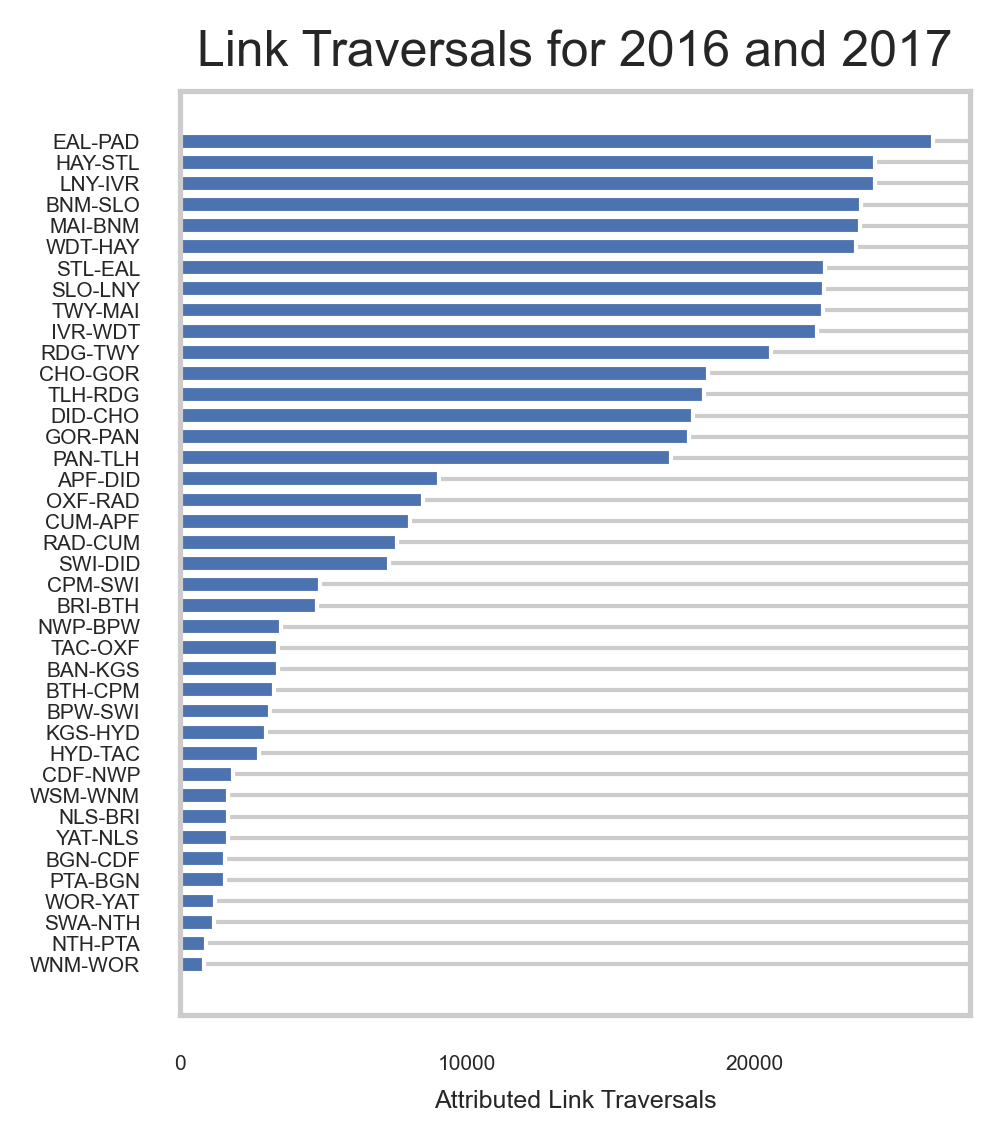

In [25]:
label2traversals = {}
idx2traversals = {}

for i in range(len(n_trains_total)):
    label2traversals[LG_node_label[LG_idx2node[i]]] = int(n_trains_total[i].item())
    idx2traversals[i] = int(n_trains_total[i].item())
    
idx2traversals = {k: v for k, v in sorted(idx2traversals.items(), key=lambda item: item[1], reverse=True)}

label2traversals = {k: v for k, v in sorted(label2traversals.items(), key=lambda item: item[1], reverse=True)}
labels, y = zip(*label2traversals.items())
labels = list(labels)
for i in range(len(labels)):
    labels[i] = labels[i][0:3] + "-" + labels[i][3:]
    
x = np.arange(0, len(y))
x = sorted(x, reverse=True)
y = sorted(y, reverse=True)

fig, ax = plt.subplots(figsize=(3.4, 4), dpi=dpi)
plt.barh(x,y)
# plt.ylabel("Link Name")
plt.xlabel("Attributed Link Traversals", fontsize=6)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
ax.set(yticks=x, yticklabels=labels)
plt.grid(axis="x")
plt.title("Link Traversals for 2016 and 2017")
plt.show()

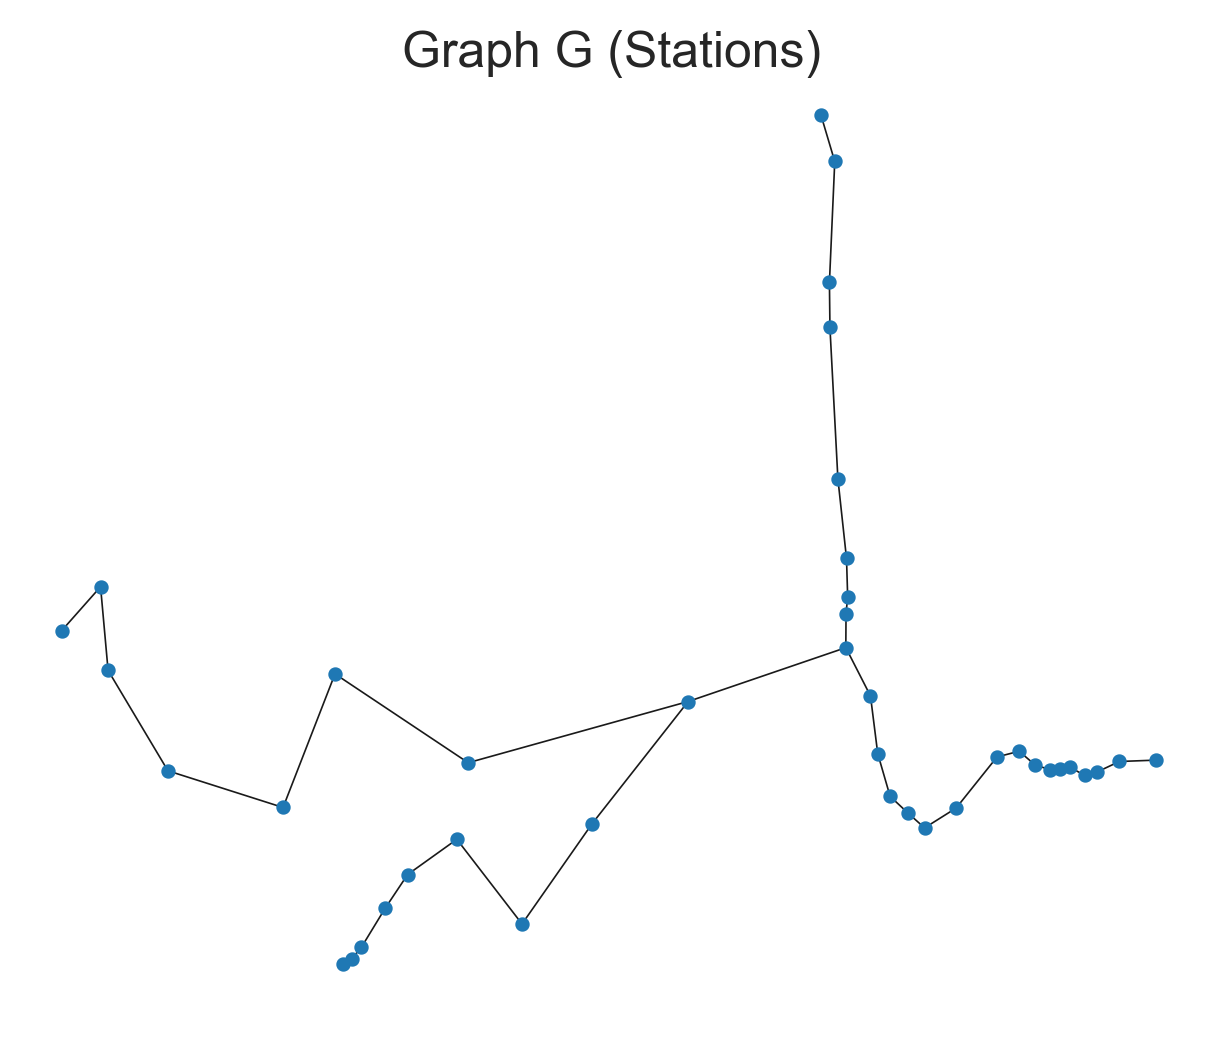

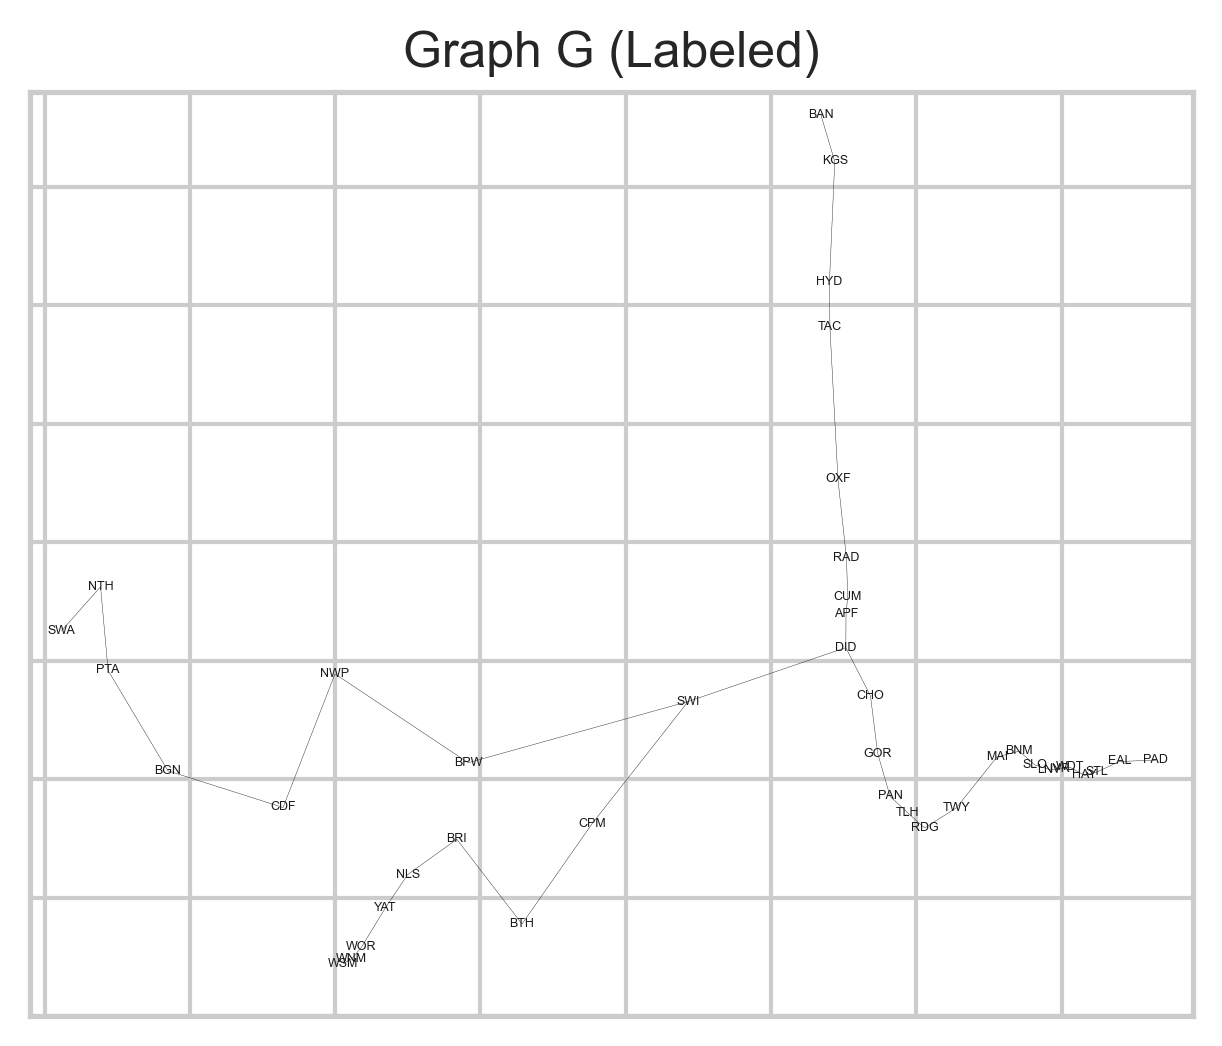

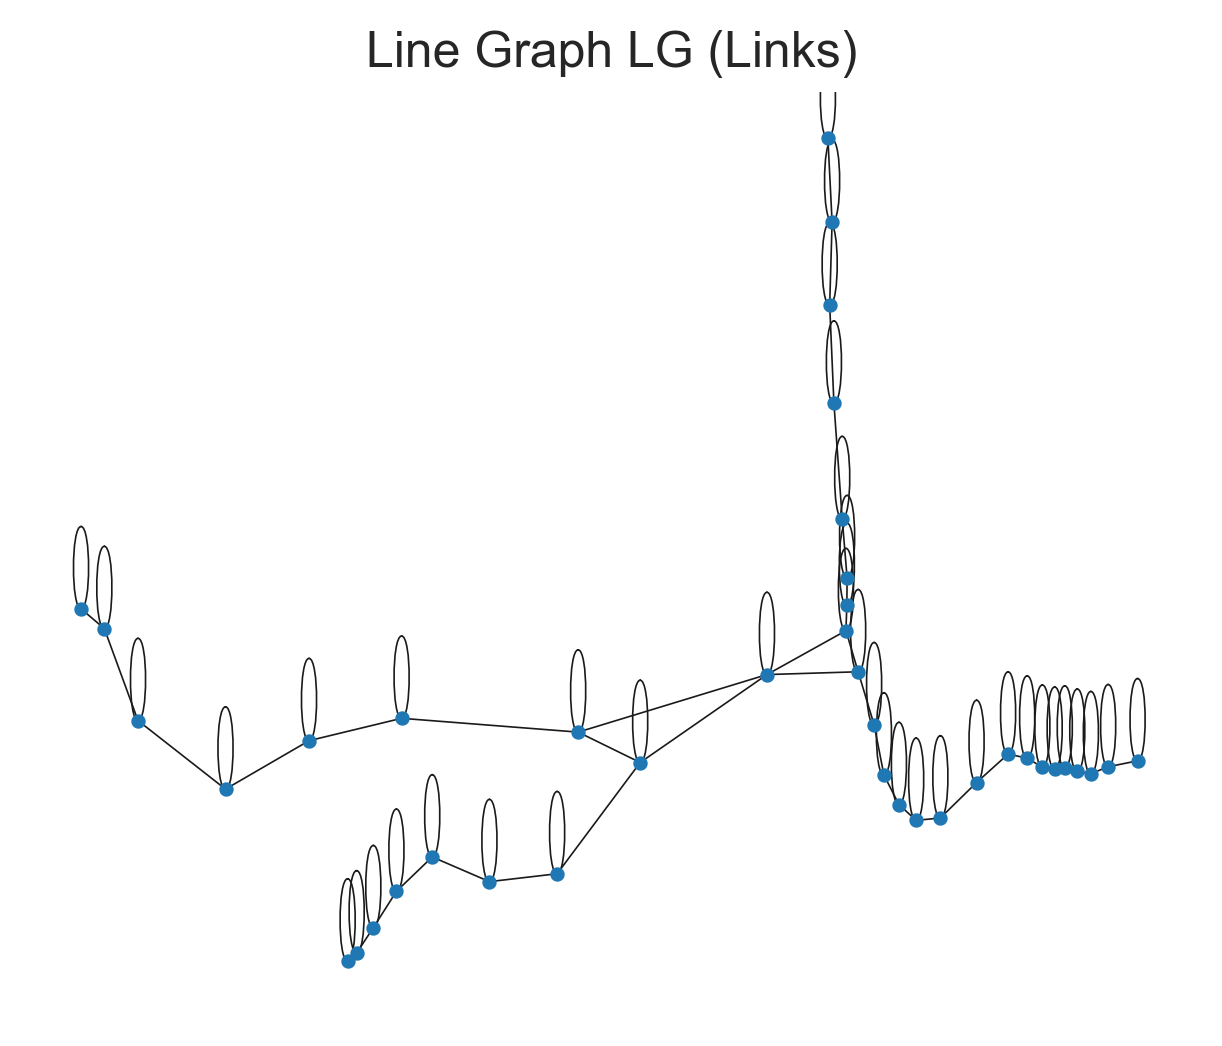

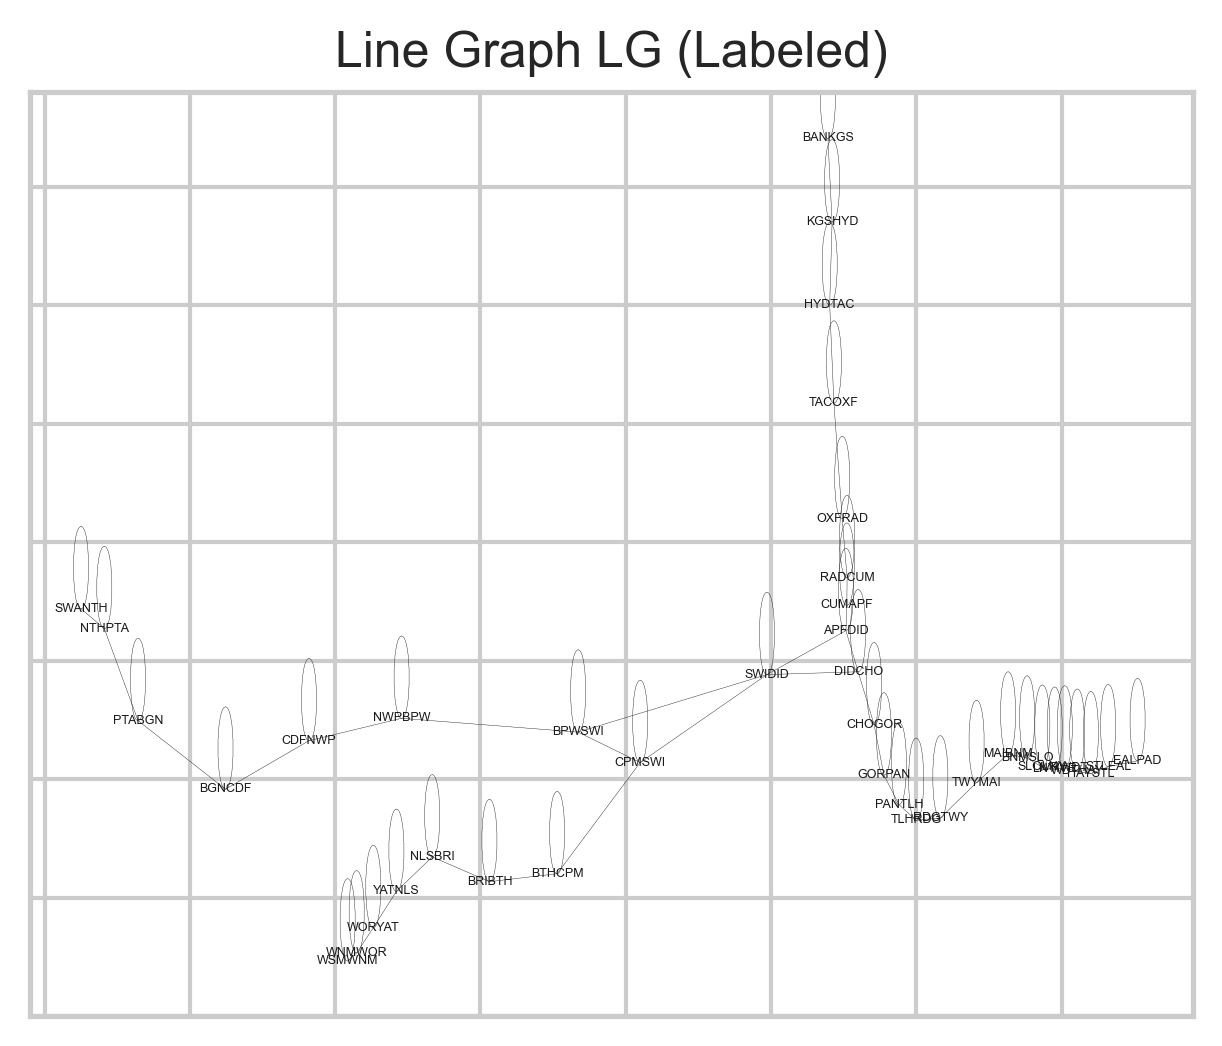

In [26]:
## graph with dots at station locations
fig = plt.subplots(figsize=figsize, dpi=dpi)
nx.draw(G, G_idx2location, node_size=node_size, width=0.4)
plt.xlim(-4.05, -0.05)
plt.ylim(51.3, 52.08)
plt.title("Graph G (Stations)")
plt.show()

## graph with labels at station locations
fig = plt.subplots(figsize=figsize, dpi=dpi)
nx.draw_networkx_labels(G, G_idx2location, G_idx2stop, font_size=3)
nx.draw_networkx_edges(G, G_idx2location, width=0.1)
plt.xlim(-4.05, -0.05)
plt.ylim(51.3, 52.08)
plt.title("Graph G (Labeled)")
plt.show()

## line graph with dots at link locations
fig = plt.subplots(figsize=figsize, dpi=dpi)
nx.draw(LG, LG_node2location, node_size=node_size, width=0.4)
plt.xlim(-4.05, -0.05)
plt.ylim(51.3, 52.08)
plt.title("Line Graph LG (Links)")
plt.show()

## line grpah with labels at link locations
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
nx.draw_networkx_labels(LG, LG_node2location, LG_node2label, font_size=3)
nx.draw_networkx_edges(LG, LG_node2location, width=0.1)
plt.xlim(-4.05, -0.05)
plt.ylim(51.3, 52.08)
plt.title("Line Graph LG (Labeled)")
plt.show()

--- STARTING VALIDATION CHECK ---

--- 1. Checking adj.npy ---
Shape: (40, 40)
Data Type: float64
Shape is (40, 40). Correct! 
Data Type is float64. Correct! 
Plotting matrix (should not be all black):


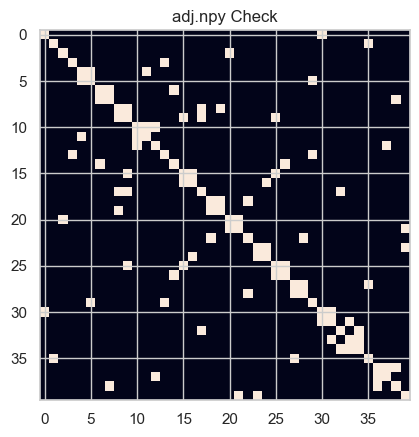


--- 2. Checking dataset.npy ---
Shape: (21336, 40, 6)
Data Type: float64
Shape is (21336, 40, 6). WRONG!  Should be (timesteps, 40, 5).
Data Type is float64. Correct! 
No NaN values. Correct! 
Contains 3770923 non-zero delay values. Correct! 
Mean delay (minutes): 0.07
Max delay (minutes): 56.00
Min delay (minutes): -11.00

--- 3. Checking JSON Mappings ---
G_stop2idx.json loaded. Correct! 
Example stations: [('SWA', 0), ('NTH', 1), ('PTA', 2)]

--- VALIDATION CHECK COMPLETE ---


In [27]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt

print("--- STARTING VALIDATION CHECK ---")
processed_dir = "./data/processed/"

# --- 1. Check adj.npy (Adjacency Matrix) ---
print("\n--- 1. Checking adj.npy ---")
try:
    adj_path = os.path.join(processed_dir, "adj.npy")
    adj_matrix = np.load(adj_path)
    
    print(f"Shape: {adj_matrix.shape}")
    print(f"Data Type: {adj_matrix.dtype}")
    
    # Check for correct shape
    if adj_matrix.shape == (40, 40):
        print("Shape is (40, 40). Correct! ")
    else:
        print(f"Shape is {adj_matrix.shape}. WRONG!  Should be (40, 40).")
        
    # Check for correct data type
    if adj_matrix.dtype == 'float64':
        print("Data Type is float64. Correct! ")
    else:
        print(f"Data Type is {adj_matrix.dtype}. WRONG!  Should be float64.")
        
    print("Plotting matrix (should not be all black):")
    plt.imshow(adj_matrix)
    plt.title("adj.npy Check")
    plt.show()

except Exception as e:
    print(f"Error loading adj.npy: {e} ")


# --- 2. Check dataset.npy (Delay Data) ---
print("\n--- 2. Checking dataset.npy ---")
try:
    dataset_path = os.path.join(processed_dir, "dataset.npy")
    dataset = np.load(dataset_path)
    
    print(f"Shape: {dataset.shape}")
    print(f"Data Type: {dataset.dtype}")
    
    # Check for correct shape (Now with 5 features!)
    if len(dataset.shape) == 3 and dataset.shape[1] == 40 and dataset.shape[2] == 5:
        print(f"Shape is ({dataset.shape[0]}, 40, 5). Correct! ")
    else:
        print(f"Shape is {dataset.shape}. WRONG!  Should be (timesteps, 40, 5).")
        
    # Check for correct data type
    if dataset.dtype == 'float64':
        print("Data Type is float64. Correct! ")
    else:
        print(f"Data Type is {dataset.dtype}. WRONG!  Should be float64.")
        
    # Check for NaN (Not a Number) or Inf (Infinity)
    if np.isnan(dataset).any():
        print("Contains NaN values! WRONG! ")
    else:
        print("No NaN values. Correct! ")
        
    # Check for all zeros
    non_zero_count = np.count_nonzero(dataset)
    if non_zero_count == 0:
        print("Dataset is ALL ZEROS! WRONG!  This will not work.")
    else:
        print(f"Contains {non_zero_count} non-zero delay values. Correct! ")
        
    # Check data statistics (Feature 0 is Delay)
    print(f"Mean delay (minutes): {np.mean(dataset[:,:,0]):.2f}")
    print(f"Max delay (minutes): {np.max(dataset[:,:,0]):.2f}")
    print(f"Min delay (minutes): {np.min(dataset[:,:,0]):.2f}")

except Exception as e:
    print(f"Error loading dataset.npy: {e} ")

# --- 3. Check JSON Mapping Files ---
print("\n--- 3. Checking JSON Mappings ---")
try:
    with open(os.path.join(processed_dir, "G_stop2idx.json"), 'r') as f:
        g_stop2idx = json.load(f)
    print("G_stop2idx.json loaded. Correct! ")
    print("Example stations:", list(g_stop2idx.items())[:3])
except Exception as e:
    print(f"Error loading G_stop2idx.json: {e} ")

print("\n--- VALIDATION CHECK COMPLETE ---")

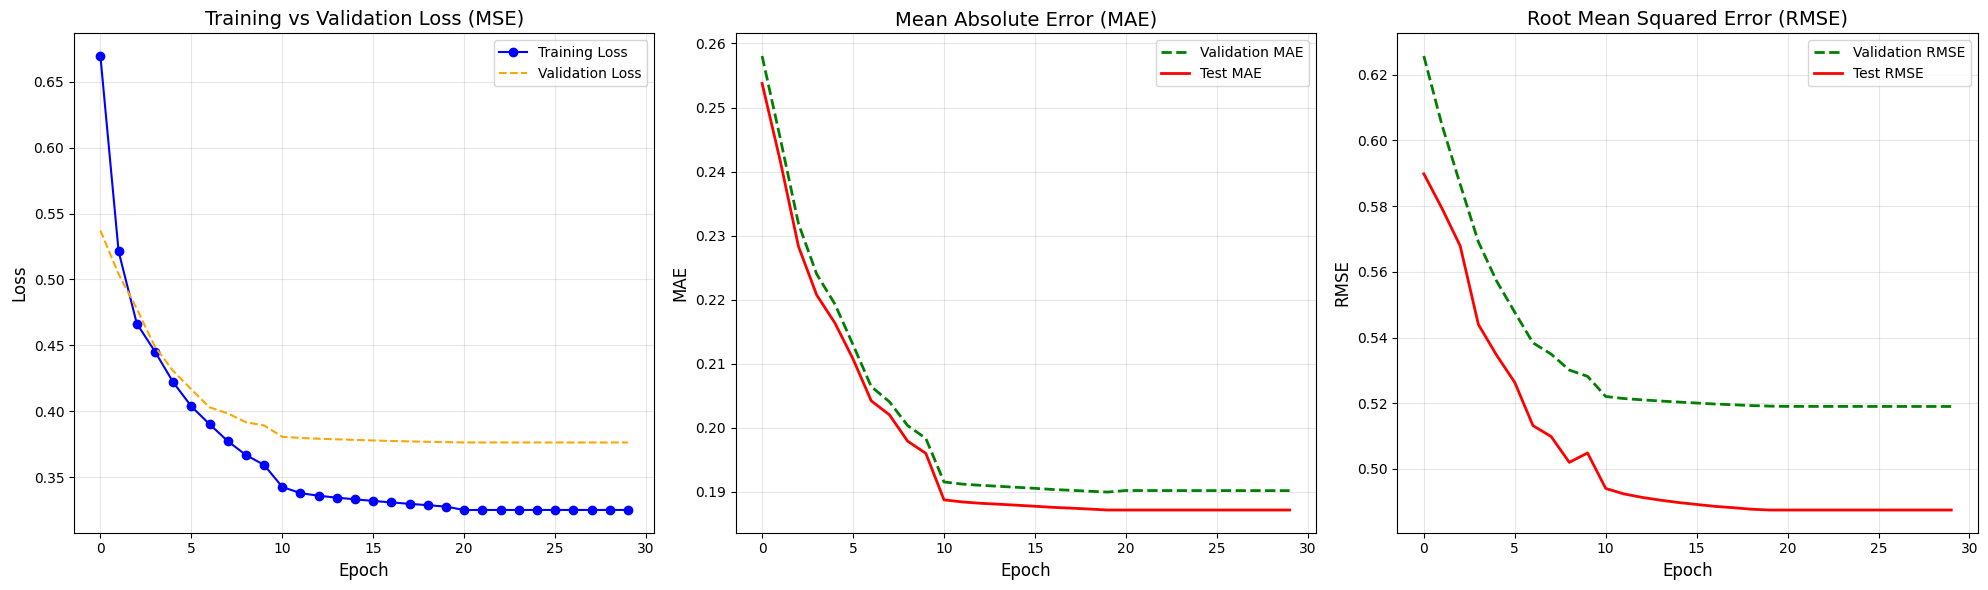

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os

history_path = r"C:\Users\sumit\Downloads\railway_delays\railway_delays\models\checkpoints\training_history.csv"

if os.path.exists(history_path):
    df = pd.read_csv(history_path)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: Training vs Validation Loss (MSE) <--- THIS IS NEW
    axes[0].plot(df['epoch'], df['train_loss'], label='Training Loss', color='blue', marker='o')
    axes[0].plot(df['epoch'], df['val_loss'], label='Validation Loss', color='orange', linestyle='--')
    axes[0].set_title("Training vs Validation Loss (MSE)", fontsize=14)
    axes[0].set_xlabel("Epoch", fontsize=12)
    axes[0].set_ylabel("Loss", fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Plot 2: MAE
    axes[1].plot(df['epoch'], df['val_mae'], label='Validation MAE', color='green', linestyle='--', linewidth=2)
    axes[1].plot(df['epoch'], df['test_mae'], label='Test MAE', color='red', linewidth=2)
    axes[1].set_title("Mean Absolute Error (MAE)", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=12)
    axes[1].set_ylabel("MAE", fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Plot 3: RMSE
    axes[2].plot(df['epoch'], df['val_rmse'], label='Validation RMSE', color='green', linestyle='--', linewidth=2)
    axes[2].plot(df['epoch'], df['test_rmse'], label='Test RMSE', color='red', linewidth=2)
    axes[2].set_title("Root Mean Squared Error (RMSE)", fontsize=14)
    axes[2].set_xlabel("Epoch", fontsize=12)
    axes[2].set_ylabel("RMSE", fontsize=12)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("File not found.")

In [11]:
# Ensure pandas is imported (just in case)
import pandas as pd
import os

# Load the data again to be safe
history_path = r"C:\Users\sumit\Downloads\railway_delays\railway_delays\models\checkpoints\training_history.csv"

if os.path.exists(history_path):
    df = pd.read_csv(history_path)

    # --- 5. Print Metric Values ---
    
    # Find the "Best" Epoch (where Validation MAE was lowest)
    best_epoch_index = df['val_mae'].idxmin()
    best_row = df.loc[best_epoch_index]

    # Get the Last Epoch
    last_row = df.iloc[-1]

    print("\n" + "="*50)
    print(f"{' TRAINING REPORT ':^50}")
    print("="*50)

    print(f"\n BEST MODEL (Found at Epoch {int(best_row['epoch'])})")
    print(f"   • Validation MAE  : {best_row['val_mae']:.4f}")
    print(f"   • Validation RMSE : {best_row['val_rmse']:.4f}")
    print(f"   • Test MAE        : {best_row['test_mae']:.4f}")
    print(f"   • Test RMSE       : {best_row['test_rmse']:.4f}")

    print(f"\n FINAL EPOCH (Epoch {int(last_row['epoch'])})")
    print(f"   • Training Loss   : {last_row['train_loss']:.6f}")
    print(f"   • Validation MAE  : {last_row['val_mae']:.4f}")
    print(f"   • Test MAE        : {last_row['test_mae']:.4f}")
    
    print("\n" + "="*50)
else:
    print("History file not found.")


                 TRAINING REPORT                  

 BEST MODEL (Found at Epoch 19)
   • Validation MAE  : 0.1900
   • Validation RMSE : 0.5191
   • Test MAE        : 0.1872
   • Test RMSE       : 0.4875

 FINAL EPOCH (Epoch 29)
   • Training Loss   : 0.325307
   • Validation MAE  : 0.1902
   • Test MAE        : 0.1872

